## Global sensitivity analysis using Sobol's method

Here, we perform a global sensitivity analysis for the endemic equilibria (for the states variable $H_w$, $A_w$, $H_m$, $A_m$) of the two-strain SHAR model proposed by Saldana et al.

In [1]:
# Import the necessary libraries

from __future__ import division
import pylab as pl
import numpy as np
from scipy.integrate import odeint
from SALib.sample import saltelli
from SALib.analyze import sobol

import matplotlib.pyplot as plt

### Code chunk 1: Setting the parameters and IC 

In [2]:
N = 100000
Hw0 = 1000 # IC 10 # EE 52000
Aw0 = 2000 # IC 10 # EE 63000
Hm0 = 50
Am0 = 50 
S0 = N - Hw0 -Aw0 - Hm0 - Am0
R0 = 0

"""
   model parameters
"""

gammaW = 1/5  # base gamma_w=1/20 =0.05
gammaM = 1/7  # base gamma_m=0.05
alpha = 1/10 # a/alpha = mean duration of natural immunity

beta_w = 1.5*gammaW # transmission rate wild type 1.2
phi_w = 1.6 # change of infectivity Aw versus the infectivity of Hw

beta_m = 1.5*gammaM # transmission rate mutant 1.4
phi_m = 2.0 # change of infectivity Am versus the infectivity of Hm

eta_w =0.45 # fraction that develops severe disease after wild-type infection 
eta_m =0.2 # fraction that develops severe disease after mutant infection

eps = 0.0001 # fraction of infections that mutate

rho = 1e-5 # spillover transmission rate 


R0w = (eta_w + (1-eta_w)*phi_w)*beta_w/gammaW
print('Wild-type R0', R0w)

R0m = (eta_m + (1-eta_m)*phi_m)*beta_m/gammaM
print('Mutant-type R0', R0m)

Wild-type R0 1.9950000000000003
Mutant-type R0 2.6999999999999997


### Code chunk 2: Define the model equations in terms of the parameter x of interest

In [3]:
# Define the model equations

def model(y, t, x):
    S, Hw, Aw, Hm, Am, R=y
    gammaW = x[0]
    gammaM = x[1]
    alpha = x[2]
    beta_w = x[3]
    phi_w = x[4]
    beta_m = x[5]
    phi_m = x[6]
    eta_w = x[7]
    eta_m = x[8]
    eps = x[9]
    rho = x[10]
    # Equations
    dSdt = -beta_w*(S/N)*(Hw + phi_w*Aw + rho*N) - beta_m*(S/N)*(Hm + phi_m*Am) + alpha*R
    dHwdt = eta_w*(1.-eps)*beta_w*(S/N)*(Hw + phi_w*Aw + rho*N) - gammaW*Hw
    dAwdt = (1.-eta_w)*(1.-eps)*beta_w*(S/N)*(Hw + phi_w*Aw + rho*N) - gammaW*Aw
    dHmdt = eta_m*beta_m*(S/N)*(Hm + phi_m*Am) + eta_w*eps*beta_w*(S/N)*(Hw + phi_w*Aw + rho*N) - gammaM*Hm
    dAmdt = (1.-eta_m)*beta_m*(S/N)*(Hm + phi_m*Am) + (1.-eta_w)*eps*beta_w*(S/N)*(Hw + phi_w*Aw + rho*N) - gammaM*Am
    dRdt = gammaW*(Hw + Aw) + gammaM*(Hm + Am) - alpha*R
    return dSdt, dHwdt, dAwdt, dHmdt, dAmdt, dRdt



# A grid of time points (in days)
t = np.linspace(0, 500, 501)

# Initial conditions vector
y0 = S0, Hw0, Aw0, Hm0, Am0, R0

# parameters
x = (gammaW, gammaM, alpha, beta_w, phi_w, beta_m, phi_m, eta_w, eta_m, eps, rho)

# Solution of the model
sol = odeint(model, y0, t, args=(x,))
S, Hw, Aw, Hm, Am, R = sol.T

plt.style.use('seaborn')



### Define the quantity of interest ($A_{w}^{*}$) in terms of a vector of parameters $x$. The vector $x$ are the parameters for the sensitivity exploration.

In [4]:
# Defining HwStar as the Hw[-1] for long time

def AmStar(x):
    sol = odeint(model, y0, t, args=(x,))
    S, Hw, Aw, Hm, Am, R = sol.T
    return Am[-1]/N

### Code chunk 3: Defining sensitivy ranges

In [5]:
#-define a function to evaluate the values of the parameters in R0
     
def evaluate(values):
    Y = np.empty([values.shape[0]])
    for i, X in enumerate(values):
        Y[i] = AmStar(X)
    return Y



#-define the ranges for the parameters in x
    
problem = {
'num_vars': 11,  # number of parameters 
'names': ['gammaW', 'gammaM', 'alpha','beta_w','phi_w', 'beta_m', 'phi_m', 'eta_w', 'eta_m', 'eps', 'rho'], 
'bounds': [[1/7, 1/5],[1/10, 1/5],[1/60, 1/30],[1/7, (1/7)*4],[1, 2.5], [1/5, (1/5)*5], 
           [1.2, 3.0], [0.2, 0.8], [0.05, 0.5], [1e-5, 1e-1], [1e-6, 1e-2]] #ranges
}


### Code chunk 5: Computing the indices

In [ ]:
# ------------Generate samples

number_of_samples = 10000
param_values = saltelli.sample(problem, number_of_samples, calc_second_order=True)
# problem represents our parameters ranges defined above
# calc_second_order=True is to compute second order indices


# ------------Run model (example)

Y = evaluate(param_values)
print(Y)


# ------------Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
#Si = sobol.analyze(problem, Y, print_to_console=False)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)


# -------------Printing some results
print("First Order Indices", Si['S1'])
print("Total Order Indices", Si['ST'])

/opt/anaconda3/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


### Code chunk 6: Plotting the results

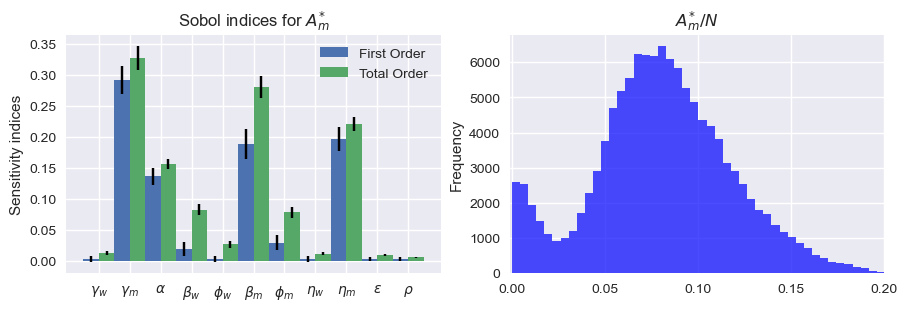

In [34]:
#---------------------- Bar plot for the Sobol indices

n = len(Si['S1'])
FirstOrder = Si['S1']
TotalOrder = Si['ST']
FOconf = Si['S1_conf']
TOconf = Si['ST_conf']
ind = np.arange(n)   # the x locations for the groups
width = 0.5     # the width of the bars: can also be len(x) sequence

fig, (ax1, ax2) = plt.subplots(figsize=(9,3), ncols=2, nrows=1, sharex=False, sharey=False, constrained_layout=True)

#-------------------- Sobol indices

p1 = ax1.bar(ind, FirstOrder, width, yerr=FOconf)
p2 = ax1.bar(ind+width, TotalOrder, width, yerr=TOconf)
#p1 = plt.bar(ind, FirstOrder, width, align='center', color='#d62728', yerr=FOconf)
#p2 = plt.bar(ind, TotalOrder, width, align='center', bottom=FirstOrder, yerr=TOconf)

ax1.set_ylabel('Sensitivity indices')
ax1.set_title(r'Sobol indices for $A_{m}^{*}$')

ax1.set_xticks(ind+width/2)
ax1.set_xticklabels((r'$\gamma_w$', r'$\gamma_m$', r'$\alpha$', r'$\beta_w$', r'$\phi_w$',
                   r'$\beta_m$', r'$\phi_m$', r'$\eta_w$', r'$\eta_m$', r'$\epsilon$', r'$\rho$'))
ax1.legend((p1[0], p2[0]), ('First Order', 'Total Order'))


# -------------------------the histogram of the data

ax2.hist(Y, bins=50, color='blue', alpha=0.7)
ax2.set_ylabel('Frequency')
#ax2.set_xlabel('$H_{w}^{*}/N$ value')
ax2.set_title(r'$A_{m}^{*}/N$')
ax2.set_xlim([-0.001, 0.2])

#plt.savefig("AmSobol.pdf", bbox_inches = 'tight')

plt.show()